In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.mstats import winsorize
from statistics import mean
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

C:\Users\V.L.S RUTHWIK\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
data = pd.read_csv("crop.csv")
data.head()

,Unnamed: 0,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,Karnataka,UDUPI,2005,Rabi,Horse-gram,1122.0,836.0
1,1,Madhya Pradesh,GWALIOR,2003,Whole Year,Brinjal,194.0,0.0
2,2,Andhra Pradesh,CHITTOOR,2010,Rabi,Sesamum,334.0,118.0
3,3,Andhra Pradesh,KRISHNA,2014,Rabi,Tomato,538.0,7289.0
4,4,Uttar Pradesh,SULTANPUR,2011,Rabi,Coriander,59.0,33.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73827 entries, 0 to 73826
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     73827 non-null  int64  
 1   State_Name     73827 non-null  object 
 2   District_Name  73827 non-null  object 
 3   Crop_Year      73827 non-null  int64  
 4   Season         73827 non-null  object 
 5   Crop           73827 non-null  object 
 6   Area           73827 non-null  float64
 7   Production     72679 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [4]:
#Check if null values are present
any(data.isna().sum()!=0)

True

In [5]:
data.dropna(inplace=True)
#Display null values in each column
data.isna().sum()

Unnamed: 0       0
State_Name       0
District_Name    0
Crop_Year        0
Season           0
Crop             0
Area             0
Production       0
dtype: int64

In [6]:
data["Production"] = winsorize(data["Production"], limits=[0.05, 0.15])

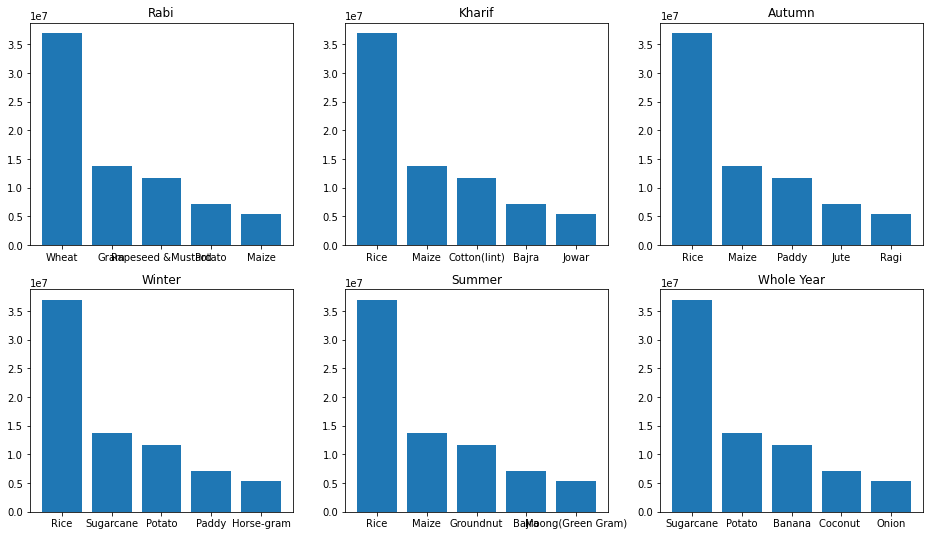

In [7]:
#Crop production of each season

#Top producted crops for each season

seasons = {}
for season in data.Season.unique():
    seasons[season.strip()] = data[data["Season"]==season].groupby("Crop").sum().sort_values("Production",ascending=False)[:5]["Production"].to_dict()

figure,ax = plt.subplots(2,3,figsize=(16,9))


ax[0,0].bar(seasons["Rabi"].keys(),seasons["Rabi"].values())
ax[0,0].set_title("Rabi")

ax[0,1].bar(seasons["Kharif"].keys(),seasons["Rabi"].values())
ax[0,1].set_title("Kharif")
ax[0,2].bar(seasons["Autumn"].keys(),seasons["Rabi"].values())
ax[0,2].set_title("Autumn")
ax[1,0].bar(seasons["Winter"].keys(),seasons["Rabi"].values())
ax[1,0].set_title("Winter")
ax[1,1].bar(seasons["Summer"].keys(),seasons["Rabi"].values())
ax[1,1].set_title("Summer")
ax[1,2].bar(seasons["Whole Year"].keys(),seasons["Rabi"].values())
ax[1,2].set_title("Whole Year")

plt.show()

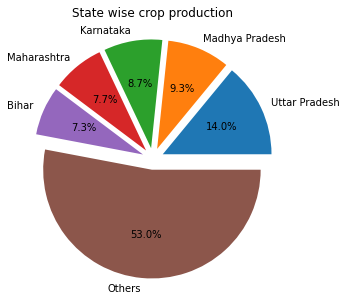

In [8]:
#Top states with highest crop production
plt.figure(figsize=(10,5))
states = data.groupby("State_Name").sum().sort_values("Production",ascending=False)[:5]["Production"].to_dict()
states["Others"] = data.groupby("State_Name").sum().sort_values("Production",ascending=False)[5:]["Production"].sum()
plt.pie(states.values(),labels=states.keys(),explode=[0.1,0.1,0.1,0.1,0.1,0.1],autopct='%.1f%%')
plt.title("State wise crop production")
plt.show()

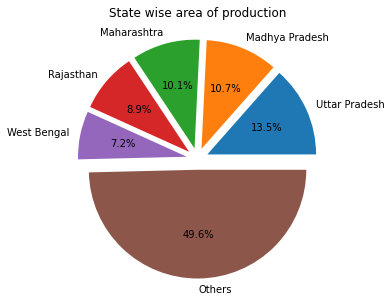

In [9]:
#Top states with highest area of production
plt.figure(figsize=(10,5))
states = data.groupby("State_Name").sum().sort_values("Area",ascending=False)[:5]["Area"].to_dict()
states["Others"] = data.groupby("State_Name").sum().sort_values("Production",ascending=False)[5:]["Area"].sum()
plt.pie(states.values(),labels=states.keys(),explode=[0.1,0.1,0.1,0.1,0.1,0.1],autopct='%.1f%%')
plt.title("State wise area of production")
plt.show()

### Forecast of crop production

In [10]:
def my_forecast(ts,n):
    """Input: timeseries
    Output: timeseries
    """
    n_step = n
    last_year = max(ts.index)+1
    model = ARIMA(ts,order=(1,1,1))
    res = model.fit()
    results = res.forecast(steps=n_step)
    results.index=list(range(last_year,last_year+n_step))
    results[last_year-1]=ts[last_year-1]
    return results.sort_index()

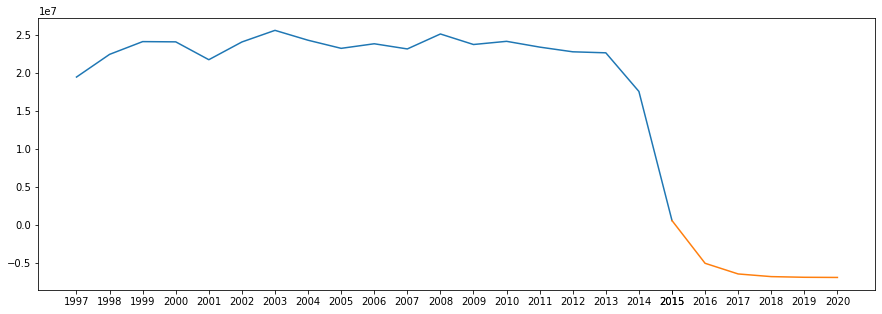

In [11]:
n_years = 5

prod_per_year = data.groupby(["Crop_Year"]).sum()["Production"]
plt.figure(figsize=(15,5))
plt.plot(prod_per_year.index,prod_per_year.values)

pred = my_forecast(prod_per_year,n_years)
plt.plot(pred.index,pred.values)
plt.xticks(pd.concat([prod_per_year,pred]).index)
plt.show()

In [12]:
#Forecast of crop production for each crop for next 5 years
crop_forecast = {}
for crop in data.Crop.unique():
    crop_ts = data[data["Crop"]==crop].groupby(["Crop_Year"]).sum()["Production"]
    try:
        pred = my_forecast(crop_ts,5)
        crop_forecast[crop] = pred.to_dict()
        #print(f"{crop} -> {pred}")
    except: pass
crop_forecast 

{'Horse-gram': {2015: 1995.6,
  2016: 23300.473737113647,
  2017: 35607.74733441303,
  2018: 42717.340438216284,
  2019: 46824.36818096009,
  2020: 49196.89170423232},
 'Brinjal': {2014: 55786.0,
  2015: 61757.4251878627,
  2016: 63998.86977940697,
  2017: 64840.22233744869,
  2018: 65156.033903611766,
  2019: 65274.5774848597},
 'Sesamum': {2015: 1475.7,
  2016: -29050.05329876867,
  2017: -21223.56013301124,
  2018: -23230.19350497519,
  2019: -22715.713085175357,
  2020: -22847.620640414683},
 'Tomato': {2014: 65605.0,
  2015: 81505.48696685958,
  2016: 89525.29633740042,
  2017: 93570.28832248032,
  2018: 95610.48147463468,
  2019: 96639.50405699099},
 'Coriander': {2014: 13252.0,
  2015: 31553.177823434602,
  2016: 34264.542400505605,
  2017: 34666.237741686426,
  2018: 34725.74989600567,
  2019: 34734.56676826838},
 'Onion': {2014: 318065.0,
  2015: 407201.49060952343,
  2016: 328446.5908084476,
  2017: 398029.0278133753,
  2018: 336550.75088363193,
  2019: 390868.7468742374},
 '

### Crops that showed high production for next 5 years

Rice               546914.588133
Banana             544867.242114
Gram               535898.292309
Cotton(lint)       519219.840073
Coconut            501241.808391
Jowar              442255.413400
Paddy              388477.232476
Onion              363193.601165
Arhar/Tur          318258.672468
Total foodgrain    311747.830093
dtype: float64


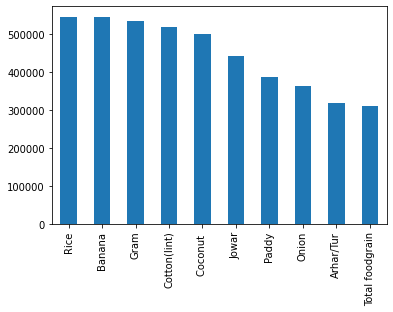

In [13]:
#Crops that are suggested to grow for next 5 years
#top 10
crop_avg_future_prod = pd.Series()
for crop in crop_forecast:
    crop_avg_future_prod[crop] = mean(crop_forecast[crop].values())
crop_avg_future_prod.sort_values(ascending=False,inplace=True)
crop_avg_future_prod[:10].plot(kind="bar")
print(crop_avg_future_prod[:10])
plt.show()

### Crop Productivity

In [16]:
crops = data.groupby(["Crop"]).mean()
crops["Production"] = winsorize(crops["Production"], limits=[0.05, 0.15])
crops["Productivity"] = crops["Production"]/crops["Area"]
crops = crops.sort_values("Productivity",ascending=False)
crops

,Unnamed: 0,Crop_Year,Area,Production,Productivity
Crop,,,,,
Papaya,36159.962733,2005.403727,248.819876,4216.881988,16.947529
Cabbage,40281.426230,2005.327869,107.950820,1405.491803,13.019742
Pome Granet,35121.266667,2006.800000,243.533333,2879.933333,11.825623
Pineapple,35235.685714,2007.142857,740.771429,7207.664375,9.729944
Colocosia,51381.000000,2013.000000,545.000000,5185.000000,9.513761
...,...,...,...,...,...
Oilseeds total,36969.170940,2004.393162,134762.487179,4575.059829,0.033949
Beet Root,20121.000000,2002.333333,117.333333,3.000000,0.025568
Cucumber,33375.766667,2002.533333,139.833333,3.000000,0.021454


<AxesSubplot:xlabel='Crop'>

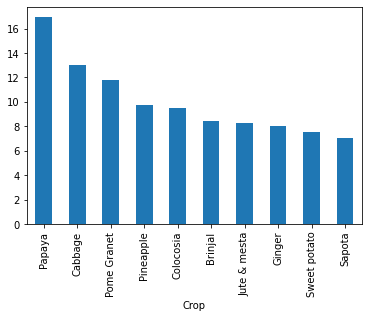

In [17]:
crops["Productivity"][:10].plot(kind="bar")

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


variables = ["State_Name","District_Name","Season","Crop","Area"]

X = data[variables]
y = data["Production"]

le = LabelEncoder()
for i in X.select_dtypes(include=["object"]):
    X[i] = le.fit_transform(X[i])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)


In [19]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

5839263.378790124